In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import SGD ,AdamW

from datasets import load_dataset, load_metric

import matplotlib.pyplot as plt

import json
from statistics import mean


In [2]:
import utils_generic as generic
import multitask_dep as mt
import model_confs as confs
import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tasks = ['to','as','about']

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'brk'

# Datos ConvAI

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = mt.Vocabulary(data['train'],encoding_type)

convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [7]:
convai_train_dataset = mt.DatasetMultitaskDep(convai_train_token,tasks,eval=False)
convai_val_dataset = mt.DatasetMultitaskDep(convai_val_token,tasks,eval=False)

# Datos md_gender

In [8]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [9]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 
md_dataset = mt.DatasetMultitaskDep(md_tokenized,tasks,eval=True)

# Creación dataloaders

In [10]:
dl_train =DataLoader(convai_train_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_val =DataLoader(convai_val_dataset,batch_size=128,shuffle=True,collate_fn=mt.collate_fn)
dl_eval = DataLoader(md_dataset,batch_size=128,shuffle=False,collate_fn=mt.collate_fn)

# Modelo multitask

In [11]:
num_epochs = 100
learning_rate = 1e-6

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0470234776623157 	 Validation loss: 2.003600233692234 	 
  1%|          | 574/57400 [03:27<4:43:26,  3.34it/s]
Epoch 2 	 Training loss: 1.988685743110936 	 Validation loss: 1.986882619938608 	 
  2%|▏         | 1148/57400 [06:53<3:49:52,  4.08it/s]
Epoch 3 	 Training loss: 1.97717895865025 	 Validation loss: 1.9731130822230194 	 
  3%|▎         | 1722/57400 [09:26<3:48:05,  4.07it/s]
Epoch 4 	 Training loss: 1.972028025351335 	 Validation loss: 1.980798602104187 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [11:57<3:02:41,  5.03it/s]
Epoch 5 	 Training loss: 1.970047486991417 	 Validation loss: 1.9725898524462167 	 
  5%|▌         | 2870/57400 [14:54<5:38:04,  2.69it/s]
Epoch 6 	 Training loss: 1.9652569898329546 	 Validation loss: 1.9724514888504805 	 
  6%|▌         | 3444/57400 [18:41<5:33:21,  2.70it/s]
Epoch 7 	 Training loss: 1.9624384016525456 	 Validation loss: 1.9760576365357738 	 

1 epoch without improvement
  7%|▋         | 4018/5740

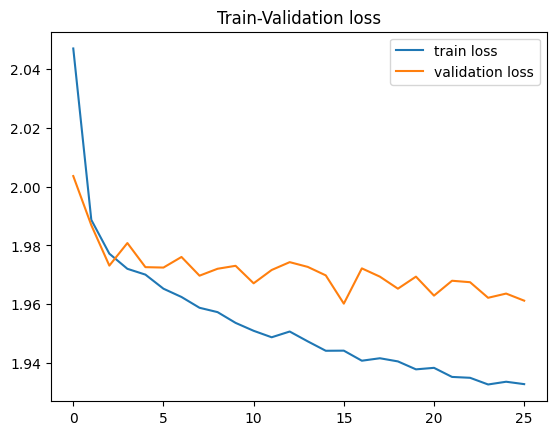

In [12]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_brk_1'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [13]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6565656565656566, 'precision': 0.6565656565656566, 'f1': 0.6565656565656566, 'accuracy': 0.6565656565656566}, 'as': {'recall': 0.7209908735332464, 'precision': 0.7209908735332464, 'f1': 0.7209908735332464, 'accuracy': 0.7209908735332464}, 'about': {'recall': 0.8150510204081632, 'precision': 0.8150510204081632, 'f1': 0.8150510204081632, 'accuracy': 0.8150510204081632}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7031630170316302, 'precision': 0.7031630170316302, 'f1': 0.7031630170316302, 'accuracy': 0.7031630170316302}, 'as': {'recall': 0.7070707070707071, 'precision': 0.7070707070707071, 'f1': 0.7070707070707071, 'accuracy': 0.7070707070707071}, 'about': {'recall': 0.84375, 'precision': 0.84375, 'f1': 0.84375, 'accuracy': 0.84375}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6062992125984252, 'precision': 0.6062992125984252, 'f1': 0.6062992125984252, 'accuracy': 0.6062992125984252}, 'as': {'recall': 0.7358490566037735, 'precisio

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0449471361545735 	 Validation loss: 2.006536128157276 	 
  1%|          | 574/57400 [02:58<4:35:35,  3.44it/s]
Epoch 2 	 Training loss: 1.9906914882128246 	 Validation loss: 1.9951032137466689 	 
  2%|▏         | 1148/57400 [05:45<4:49:12,  3.24it/s]
Epoch 3 	 Training loss: 1.9805022480180454 	 Validation loss: 1.994995010101189 	 
  3%|▎         | 1722/57400 [08:31<4:15:19,  3.63it/s]
Epoch 4 	 Training loss: 1.9725844143575078 	 Validation loss: 1.9768025834681624 	 
  4%|▍         | 2296/57400 [11:23<3:42:28,  4.13it/s]
Epoch 5 	 Training loss: 1.9685939193187274 	 Validation loss: 1.9767589144787545 	 
  5%|▌         | 2870/57400 [15:09<4:56:32,  3.06it/s]
Epoch 6 	 Training loss: 1.9635857576277198 	 Validation loss: 1.9819974535602634 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [18:42<4:25:47,  3.38it/s]
Epoch 7 	 Training loss: 1.9608621098853984 	 Validation loss: 1.9645925376374842 	 
  7%|▋         | 4018/57400 [21:57<4:40:36,  3.17

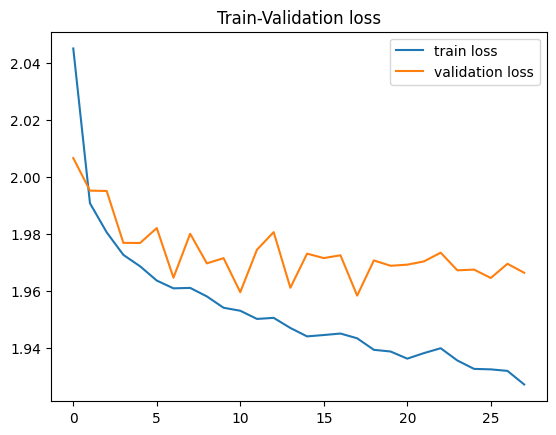

In [14]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_brk_2'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [15]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6654040404040404, 'precision': 0.6654040404040404, 'f1': 0.6654040404040404, 'accuracy': 0.6654040404040404}, 'as': {'recall': 0.7183833116036505, 'precision': 0.7183833116036505, 'f1': 0.7183833116036505, 'accuracy': 0.7183833116036505}, 'about': {'recall': 0.8048469387755102, 'precision': 0.8048469387755102, 'f1': 0.8048469387755102, 'accuracy': 0.8048469387755102}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7007299270072993, 'precision': 0.7007299270072993, 'f1': 0.7007299270072993, 'accuracy': 0.7007299270072993}, 'as': {'recall': 0.6893939393939394, 'precision': 0.6893939393939394, 'f1': 0.6893939393939394, 'accuracy': 0.6893939393939394}, 'about': {'recall': 0.8255208333333334, 'precision': 0.8255208333333334, 'f1': 0.8255208333333334, 'accuracy': 0.8255208333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6272965879265092, 'precision': 0.6272965879265092, 'f1': 0.6272965879265092, 'accuracy': 0.6272965879265092}, 'a

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 2.0567740160413734 	 Validation loss: 2.0126573231260654 	 
  1%|          | 574/57400 [03:20<4:14:32,  3.72it/s]
Epoch 2 	 Training loss: 1.99288160107277 	 Validation loss: 1.989177111851967 	 
  2%|▏         | 1148/57400 [06:19<3:32:47,  4.41it/s]
Epoch 3 	 Training loss: 1.9785902761831515 	 Validation loss: 1.9758496122845148 	 
  3%|▎         | 1722/57400 [09:04<4:12:35,  3.67it/s]
Epoch 4 	 Training loss: 1.9720837465562056 	 Validation loss: 1.981515225717577 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [11:50<4:23:05,  3.49it/s]
Epoch 5 	 Training loss: 1.9676110806780824 	 Validation loss: 1.9809252407591222 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [14:39<4:33:36,  3.32it/s]
Epoch 6 	 Training loss: 1.9651106018637947 	 Validation loss: 1.9787439936298434 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [18:00<5:11:36,  2.89it/s]
Epoch 7 	 Training loss: 1.9606826313696673 	 Validation loss: 1.9868836039203

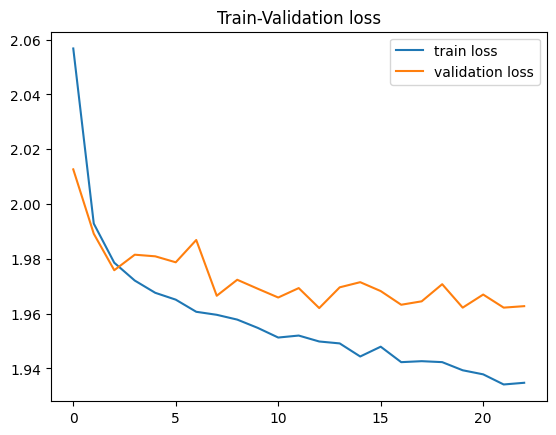

In [16]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
save_path='distilbert_multitask_brk_3'
train.train_function_multi(model,num_epochs,dl_train,optimizer,early_stop = 10,dl_val = dl_val,save_path=save_path,es_threshold=0)

In [17]:
model = mt.MultiWithDependencies(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))

print("Evaluación del modelo")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender=None)
generic.update_global_metric_multi(result_global,global_metrics,mtype='global')
print(result_global,'\n')
print("Evaluación en etiquetas male")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='male')
generic.update_global_metric_multi(result_global,global_metrics,mtype='male')
print(result_global,'\n')
print("Evaluación en etiquetas female")
result_global = train.eval_func_multi(model,dl_eval,tasks,gender='female')
generic.update_global_metric_multi(result_global,global_metrics,mtype='female')
print(result_global,'\n')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación del modelo
{'to': {'recall': 0.6616161616161617, 'precision': 0.6616161616161617, 'f1': 0.6616161616161617, 'accuracy': 0.6616161616161617}, 'as': {'recall': 0.7092568448500652, 'precision': 0.7092568448500652, 'f1': 0.7092568448500652, 'accuracy': 0.7092568448500652}, 'about': {'recall': 0.8163265306122449, 'precision': 0.8163265306122449, 'f1': 0.8163265306122449, 'accuracy': 0.8163265306122449}} 

Evaluación en etiquetas male
{'to': {'recall': 0.7007299270072993, 'precision': 0.7007299270072993, 'f1': 0.7007299270072993, 'accuracy': 0.7007299270072993}, 'as': {'recall': 0.702020202020202, 'precision': 0.702020202020202, 'f1': 0.702020202020202, 'accuracy': 0.702020202020202}, 'about': {'recall': 0.8411458333333334, 'precision': 0.8411458333333334, 'f1': 0.8411458333333333, 'accuracy': 0.8411458333333334}} 

Evaluación en etiquetas female
{'to': {'recall': 0.6194225721784777, 'precision': 0.6194225721784777, 'f1': 0.6194225721784777, 'accuracy': 0.6194225721784777}, 'as': 

In [18]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8120748299319728, 'precision': 0.8120748299319728, 'f1': 0.8120748299319728, 'accuracy': 0.8120748299319728}
Métricas etiqueta male: {'recall': 0.8368055555555556, 'precision': 0.8368055555555556, 'f1': 0.8368055555555556, 'accuracy': 0.8368055555555556}
Métricas etiqueta female:  {'recall': 0.7883333333333333, 'precision': 0.7883333333333333, 'f1': 0.7883333333333333, 'accuracy': 0.7883333333333333}

 to
Resultado global: {'recall': 0.6611952861952862, 'precision': 0.6611952861952862, 'f1': 0.6611952861952862, 'accuracy': 0.6611952861952862}
Métricas etiqueta male: {'recall': 0.7015409570154096, 'precision': 0.7015409570154096, 'f1': 0.7015409570154096, 'accuracy': 0.7015409570154096}
Métricas etiqueta female:  {'recall': 0.6176727909011374, 'precision': 0.6176727909011374, 'f1': 0.6176727909011374, 'accuracy': 0.6176727909011374}

 as
Resultado global: {'recall': 0.7162103433289874, 'precision': 0.7162103433289874, 'f1': 0.7